# Overview

・コンジョイント分析とは、最適な商品コンセプトを決定するための多変量解析を使用した分析手法である<br>
　商品全体の評価（全体効用値）をすることで、個々の要素の購買に影響する度合い（部分効用値）を算出することができる<br>

　例えば、ユーザがPCを購入する際に、どの要素がどのくらい影響するのか（重要であるのか）を求めることができる

# Module

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Datasets

#### ・data：PCとスペックのデータ

In [2]:
data = pd.DataFrame([[1, 60000, '4GB', '128GB', 3],
                     [1, 60000, '8GB', '512GB', 9],
                     [1, 80000, '4GB', '512GB', 5],
                     [1, 80000, '8GB', '128GB', 7],
                     [2, 60000, '4GB', '128GB', 4]],
                    columns=['ans_id', 'price', 'memory', 'storage', 'rating'])
data.head()

,ans_id,price,memory,storage,rating
0,1,60000,4GB,128GB,3
1,1,60000,8GB,512GB,9
2,1,80000,4GB,512GB,5
3,1,80000,8GB,128GB,7
4,2,60000,4GB,128GB,4


In [3]:
data.to_csv('conjoint_sample')

# Preprocess

In [4]:
X = data[[col for col in data.columns if col != 'rating']]
y = data['rating']

In [5]:
X = X.drop('ans_id', axis=1)
X.head()

,price,memory,storage
0,60000,4GB,128GB
1,60000,8GB,512GB
2,80000,4GB,512GB
3,80000,8GB,128GB
4,60000,4GB,128GB


In [6]:
X_dum = pd.get_dummies(X, columns=X.columns)
X_dum.head()

,price_60000,price_80000,memory_4GB,memory_8GB,storage_128GB,storage_512GB
0,1,0,1,0,1,0
1,1,0,0,1,0,1
2,0,1,1,0,0,1
3,0,1,0,1,1,0
4,1,0,1,0,1,0


# Modeling

In [7]:
model = sm.OLS(y, sm.add_constant(X_dum))
result = model.fit()
result.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     15.13
Date:                Wed, 10 Nov 2021   Prob (F-statistic):              0.186
Time:                        02:07:32   Log-Likelihood:                -1.3382
No. Observations:                   5   AIC:                             10.68
Df Residuals:                       1   BIC:                             9.114
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4500      0.132     18.520      0.034       0.769       4.131
price_60000       1.3500      0.328      4.117      0.152      -2.816       5.516
price_80000       1.1000      0.346      3.175      0.194      -3.302       5.502
memory_4GB       -0.6500      0.328     -1.982      0.297      -4.816       3.516
memory_8GB        3.1000      0.346      8.949      0.071      -1.302       7.502
storage_128GB     0.3500      0.328      1.067      0.479      -3.816       4.516
storage_512GB     2.1000      0.346      6.062      0.104      -2.302       6.502
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.052
Skew:                          -0.000   Prob(JB):                        0.974
Kurtosis:                       2.500   Cond. No.                     2.06e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The smallest eigenvalue is 3.05e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

・coef：目的変数（評価）に対する偏回帰係数<br>
・P>|t|：P値、有意水準を下回れば、その説明変数が目的変数（評価）に影響を及ぼす要素であると判断できる

・重要な要素だけを抜き取り、下記にまとめる

In [8]:
data_res = pd.DataFrame({'name': result.params.keys(),
                         'weight': result.params.values,
                         'p_val': result.pvalues})
data_res = data_res[1:]
data_res

,name,weight,p_val
price_60000,price_60000,1.35,0.151678
price_80000,price_80000,1.10,0.194224
memory_4GB,memory_4GB,-0.65,0.297414
memory_8GB,memory_8GB,3.10,0.070845
storage_128GB,storage_128GB,0.35,0.479226
storage_512GB,storage_512GB,2.10,0.104078


・有意水準を5%とすると、全ての要素が統計的に有意でないことが分かる

In [9]:
data_res['abs_weight'] = np.abs(data_res['weight'])
data_res = data_res.sort_values(by='abs_weight')
data_res

,name,weight,p_val,abs_weight
storage_128GB,storage_128GB,0.35,0.479226,0.35
memory_4GB,memory_4GB,-0.65,0.297414,0.65
price_80000,price_80000,1.10,0.194224,1.10
price_60000,price_60000,1.35,0.151678,1.35
storage_512GB,storage_512GB,2.10,0.104078,2.10
memory_8GB,memory_8GB,3.10,0.070845,3.10


In [10]:
sns.set()

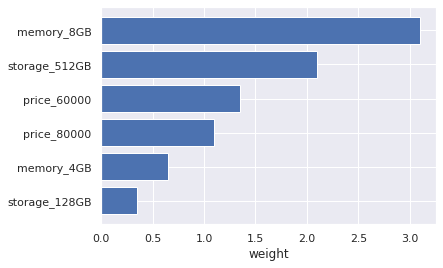

In [11]:
xbar = np.arange(len(data_res['weight']))
plt.barh(xbar, data_res['abs_weight'])
plt.yticks(xbar, labels=data_res['name'])
plt.xlabel('weight')
plt.show()

・評価に対して、最も寄与度が高いのがメモリ、次にストレージであると判断できる